# Experiment 1
Input data: DAiSEE features extracted using OpenFace2.0 in CSV files
(Step 0) Data preparation:
* [Case 1] Average all frames into 1 timesteps
* [Case 2] Average every 30 frames, resulting on 10 timesteps, export dataset in pickle

Step 1: Load data and preprocess (for case 1)

Step 2: Build models, compile, and train. 

Step 3: Evaluation

* Performance comparation between LSTM, CNN, and Classical Machine Learning Model

Check EDA repository to understand how the data were extracted and prepared 
https://github.com/shofi777/EDA.git

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential #, Input
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline
# %matplotlib notebook

# 1. Load Data and Pre-process

In [2]:
#load data
def load_data(datafile):
    df = pd.read_csv(datafile)
    df = df.drop(df.columns[0], axis=1)
    return df

#Split features and label
def split_label(df):
    df = np.array(df)
    Y = df[:,-1]
    print('Y original =', Y)
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    X = df[:,0:-1]    
    return X, Y

#Resampling
def resample(label0,label1,label2,X,Y):
    #downsampling
    strategydown = {0:label0, 1:label1, 2:label2} 
    downsample = RandomUnderSampler(sampling_strategy=strategydown) 
    X_resampled, Y_resampled = downsample.fit_resample(X, Y) #fit and apply transform
    
    #oversampling
    oversample = SMOTE()#sampling_strategy='not minority'
    X_resampled, Y_resampled = oversample.fit_resample(X_resampled, Y_resampled) #fit and apply transform
    return X_resampled, Y_resampled 

# Normalization and dimensionality reduction
def norm(X):     
    # normalize the range features
    scaler = MinMaxScaler(feature_range=(0,1))  #.fit(X_train_av)
    X = scaler.fit_transform(X)

    # PCA decomposition. Set components number from 329(original) to 200 (to 1500 for daisee_mediapipe data)
    pca = decomposition.PCA(n_components=200) #.fit(X_train_av)
    X = pca.fit_transform(X)
    
    return X #, X_inverted

#reshape to 3D data (nsample,ntimestep,nfeatures)
def reshaping(X):
    X = X.reshape(X.shape[0],1,X.shape[1]) 
    return X

## [Case 1] Averaged data input

In [3]:
df_train_av = load_data('dataset/average_train.csv')
df_val_av = load_data('dataset/average_val.csv')
df_test_av = load_data('dataset/average_test.csv')
print('Train = ', df_train_av.shape)
print('Val = ', df_val_av.shape)
print('Test = ', df_test_av.shape)

Train =  (5358, 330)
Val =  (1429, 330)
Test =  (1784, 330)


In [4]:
#Concatenate train and validation set
df_train_concat = pd.concat([df_train_av,df_val_av], axis=0, ignore_index=True)
df_all_concat = pd.concat([df_train_concat,df_test_av], axis=0, ignore_index=True)
print(df_all_concat.shape)
print(df_train_concat.shape)

(8571, 330)
(6787, 330)


In [5]:
X_train_all, Y_train_all = split_label(df_all_concat)
# X_train_av, Y_train_av = split_label(df_train_concat)
X_train_av, Y_train_av = split_label(df_train_av)
X_val_av, Y_val_av = split_label(df_val_av)
X_test_av, Y_test_av = split_label(df_test_av)

Y original = [2. 2. 3. ... 3. 3. 2.]
Y before encode = [1. 1. 2. ... 2. 2. 1.]
Y after encode = [1 1 2 ... 2 2 1]
Y original = [2. 2. 3. ... 2. 3. 3.]
Y before encode = [1. 1. 2. ... 1. 2. 2.]
Y after encode = [1 1 2 ... 1 2 2]
Y original = [2. 3. 2. ... 2. 2. 2.]
Y before encode = [1. 2. 1. ... 1. 1. 1.]
Y after encode = [1 2 1 ... 1 1 1]
Y original = [2. 2. 2. ... 3. 3. 2.]
Y before encode = [1. 1. 1. ... 2. 2. 1.]
Y after encode = [1 1 1 ... 2 2 1]


Train + Validation set:
Engagement=1, n=2617 (48.843%)
Engagement=2, n=2494 (46.547%)
Engagement=0, n=247 (4.610%)
Total= 5358

Validation-only set:
Engagement=1, n=813 (56.893%)
Engagement=2, n=450 (31.491%)
Engagement=0, n=166 (11.617%)
Total= 1429

Test set:
Engagement=1, n=882 (49.439%)
Engagement=2, n=814 (45.628%)
Engagement=0, n=88 (4.933%)
Total= 1784
[1, 2, 0]
[2617, 2494, 247]


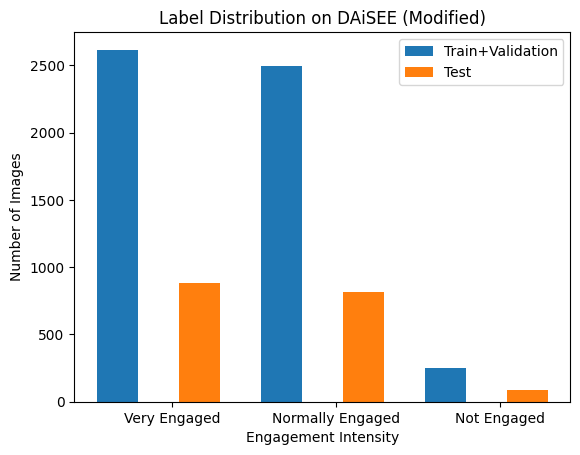

In [6]:
#Plot Distribution after concatenation train+validation
def plot_dist(Y):
    counter = Counter(Y)
    key =[]
    value = []
    for k,v in counter.items():
        per = v / len(Y)*100
        print('Engagement=%d, n=%d (%.3f%%)' % (k,v,per))
        key.append(k)
        value.append(v)
    print('Total=', len(Y))
    return key, value

print("Train + Validation set:")
k_train, v_train = plot_dist(Y_train_av)
print("\nValidation-only set:")
k_val, v_val = plot_dist(Y_val_av)
print("\nTest set:")
k_test, v_test = plot_dist(Y_test_av)
print(k_train)
print(v_train)

#Plot the distribution
ind = np.arange(len(k_train)) 
w = 0.25 
plt.bar(ind  , v_train, width=w, label='Train+Validation')
# plt.bar(ind + w, v_val, width=w, label='Validation')
plt.bar(ind + w + w, v_test, width=w,label='Test')

plt.ylabel('Number of Images')
plt.xlabel('Engagement Intensity')
plt.title('Label Distribution on DAiSEE (Modified)')
plt.xticks(ind + w + w/ 3, ('Very Engaged','Normally Engaged','Not Engaged'))

# plt.title('Engagement Label Distributions on DAiSEE')
# plt.xticks(ind + 0.08 + 0.08 + 0.08, ('3\nVery High','2\nHigh','1\nLow','0\nVery Low'))
plt.legend(loc='best')
plt.show()

In [7]:
X_train_all, Y_train_all = resample(501,2000,2000,X_train_all,Y_train_all) #413,1472,1715
# X_train_av, Y_train_av = resample(413,1000,1000,X_train_av,Y_train_av) #for combined train+val set
X_train_av, Y_train_av = resample(247,1000,1000,X_train_av,Y_train_av) #for original train set
X_val_av, Y_val_av = resample(166,200,200,X_val_av,Y_val_av)
X_test_av, Y_test_av = resample(88,441,407,X_test_av,Y_test_av)

In [8]:
X_train_all_norm = norm(X_train_all)
X_train = norm(X_train_av)
X_val_av_norm = norm(X_val_av)
X_test_av_norm = norm(X_test_av)
# print('X training=',X_train.shape)
# # print('X val=',X_val.shape)
# print('X test=',X_test.shape)
X_train_av = X_train

In [9]:
X_train_all = reshaping(X_train_all_norm)
X_train_av = reshaping(X_train_av)
X_val_av = reshaping(X_val_av_norm)
X_test_av = reshaping(X_test_av_norm) 
print('X_train_all:{} | Y_train_all:{}\nX_train_av:{} | Y_train_av:{}\nX_test_av:{} | Y_test_av:{} '.format(X_train_all.shape, Y_train_all.shape, X_train_av.shape, Y_train_av.shape, X_test_av.shape, Y_test_av.shape))

X_train_all:(6000, 1, 200) | Y_train_all:(6000,)
X_train_av:(3000, 1, 200) | Y_train_av:(3000,)
X_test_av:(1323, 1, 200) | Y_test_av:(1323,) 


In [10]:
Y_train_cat_all = to_categorical(Y_train_all)
Y_train_cat_av = to_categorical(Y_train_av) #convert label vector to one-hot matrix
Y_val_cat_av = to_categorical(Y_val_av) #convert label vector to one-hot matrix
Y_test_cat_av = to_categorical(Y_test_av) 
print('Y after convert to 1hot =', Y_train_cat_av)
print(Y_train_cat_av.shape)

Y after convert to 1hot = [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(3000, 3)


# 2. Build Models, Compile and Train

In [11]:
# CNN
def CNN(X):
    # Initialising the CNN
    model = Sequential()

    ## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
    # 1 - Convolution
    model.add(Conv1D(64,3, padding='same', input_shape=((X.shape[1],X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling1D(pool_size=2)) #downsampling/ shrink the height and width dimension by factor of 2  
   
    # 2nd Convolution layer
    model.add(Conv1D(128,5, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 3rd Convolution layer
    model.add(Conv1D(512,3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 4th Convolution layer
    model.add(Conv1D(512,3, padding='same'))#
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    # Fully connected layer 3nd layer
    model.add(Dense(512, name = 'convy'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(3, activation='softmax'))

    model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001)
    model._name='CNNmodel'
    model.summary()

    return model

In [12]:
# LSTM
# ## 1. Vanila LSTM
# - Memory cells of a single LSTM layer are used in a simple network structure
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1],X.shape[2]))) #use average data
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

# ## 2. Stacked LSTM
# - LSTM layers are stacked one on top of another into deep recurrent neural networks
def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

# ## 3. Bi-LSTM
# - Input sequences are presented and learned both forward and backward
def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

# ## 4. BiLSTM (Ensamble)
# - Follow An Ensemble model using face and body tracking for engagement detection
def bilstm_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    # model.add(Dropout(0.5))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='bilstm_en'
    print(model.summary())
    return model

In [13]:
# CNN
CNN_model = CNN(X_train_av)

#instantiate the model[Case 1]
vanilaLSTM_model = vanilaLSTM(X_train_av)
stackedLSTM_model = stackedLSTM(X_train_av)
biLSTM_model = biLSTM(X_train_av)
bilstm_en_model = bilstm_en(X_train_av)

Model: "CNNmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             38464     
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 activation_1 (Activation)   (None, 1, 128)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 128)           512       
 hNormalization)                                          

In [14]:
# #instantiate the model [Case 2]
# vanilaLSTM_model = vanilaLSTM(X_train)
# stackedLSTM_model = stackedLSTM(X_train)
# biLSTM_model = biLSTM(X_train)
# bilstm_en_model = bilstm_en(X_train)

### Fit Models and Evaluation

In [15]:
#compile and train model
def compile_train(model,Xtrain,YtrainCat):
    loss = 'categorical_crossentropy' # mse 'sparse_categorical_crossentropy'
    metrics = ['categorical_accuracy'] 
    monitor= 'val_loss' 
    lr=1e-3

    #learning rate schedule: reduce learning rate 0.1 every 2 epochs 
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=2, min_lr=0.00001, mode='auto')
    es = EarlyStopping(monitor=monitor, min_delta=0.0001, patience=50)

    model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=metrics)  
    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    history = model.fit(Xtrain,YtrainCat, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],# ,reduce_lr
                        batch_size = 32,
                        # validation_split=0.2, 
                        # validation_data=(X_test_av, Y_test_cat_av), 
                        validation_data=(X_val_av, Y_val_cat_av), 
                        shuffle=True
                        # class_weight = 'balanced'
                       )
    
    weight_file = model.save(filepath)
    # mse, acc = model.evaluate(X_train, YtrainCat, verbose=0)
    return history, weight_file

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

    #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(3),range(3))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

#### Logistic Regression

In [16]:
# Fit multiclass Logistic Regression model
tic = datetime.now()

lr = LogisticRegression(C=1, multi_class='multinomial', max_iter=1000).fit(X_train, Y_train_av)
time = datetime.now() - tic

print("Training time single training:{}".format(time))

print("Training set score: %f" % lr.score(X_train,Y_train_av))
print("Test set score: %f" % lr.score(X_test_av_norm, Y_test_av))
print("Coefficients shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

# Kfold cross validation
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
tic = datetime.now()
n_scores = cross_val_score(lr, X_train_all_norm, Y_train_all,scoring='accuracy', cv=skf, n_jobs=1)
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Training time single training:0:00:00.083001
Training set score: 0.541333
Test set score: 0.370370
Coefficients shape:  (3, 200)
Intercept shape:  (3,)
Training time for 5-fold cv:0:00:00.619000
Mean Accuracy 5-fold cv: 0.502 (0.008)


#### CNN

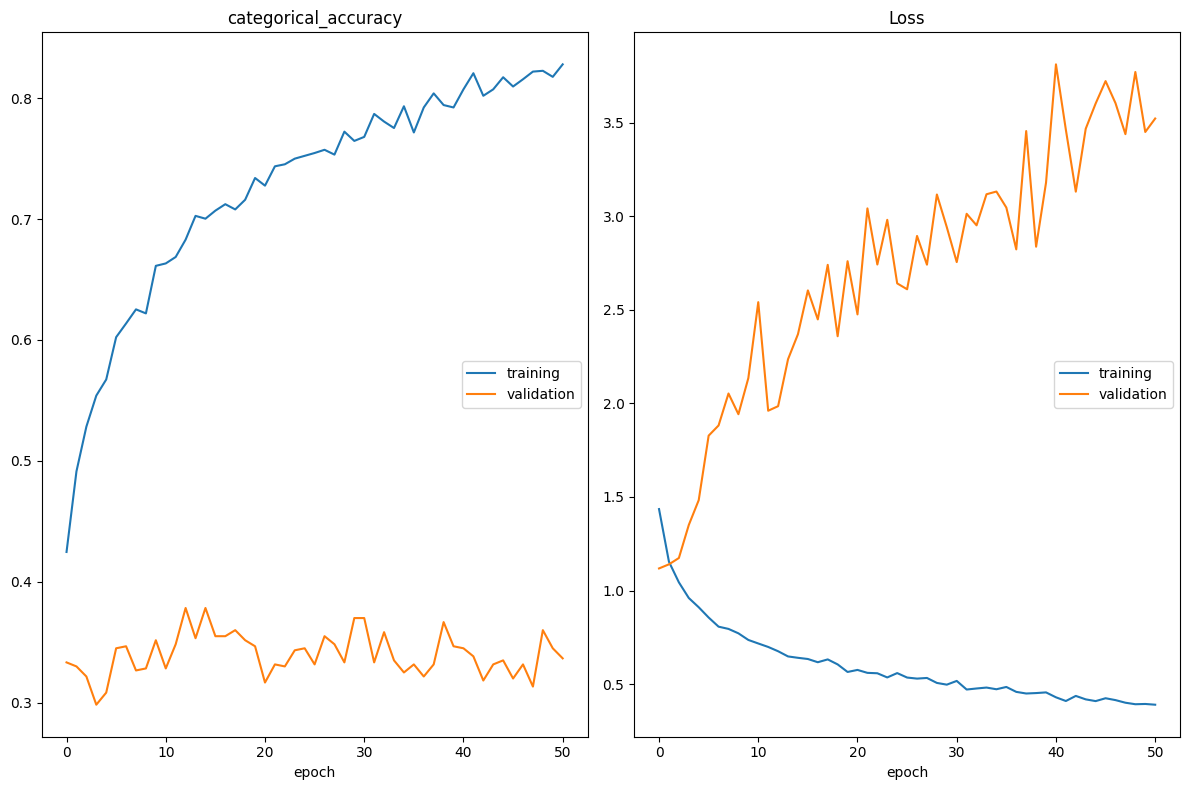

categorical_accuracy
	training         	 (min:    0.425, max:    0.828, cur:    0.828)
	validation       	 (min:    0.298, max:    0.378, cur:    0.337)
Loss
	training         	 (min:    0.390, max:    1.435, cur:    0.390)
	validation       	 (min:    1.118, max:    3.811, cur:    3.522)

Epoch 51: val_loss did not improve from 1.11838
94/94 [==============================] - 1s 9ms/step - loss: 0.3905 - categorical_accuracy: 0.8280 - val_loss: 3.5217 - val_categorical_accuracy: 0.3367
Training time:0:00:46.076117
42/42 [==============================] - 0s 3ms/step - loss: 2.8435 - categorical_accuracy: 0.3530
Accuracy on Test set: 35.30%
42/42 [==============================] - 0s 2ms/step
|CNNmodel|
 Error rate = 0.6470143613000756 
 MSE =  1.2025699168556312 
 Accuracy =  0.3529856386999244 
 AUC =  0.515709332359802 
 F1-score =  0.3485724761436111 
 Fbeta =  0.3518628138696565
None


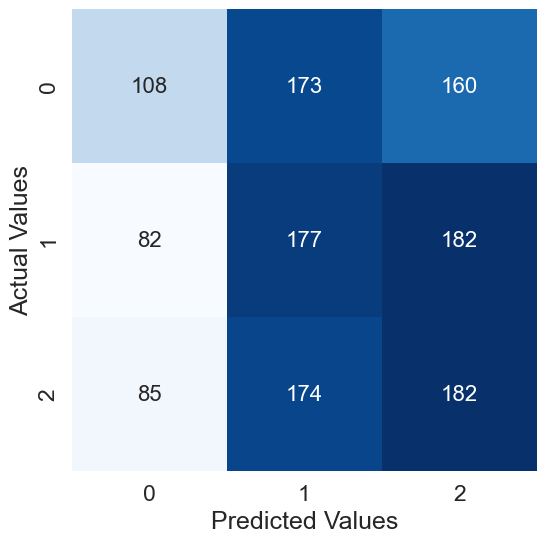

In [17]:
tic = datetime.now()
compile_train(CNN_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = CNN_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(CNN_model,X_test_av, Y_test_av))


#### SingleLSTM

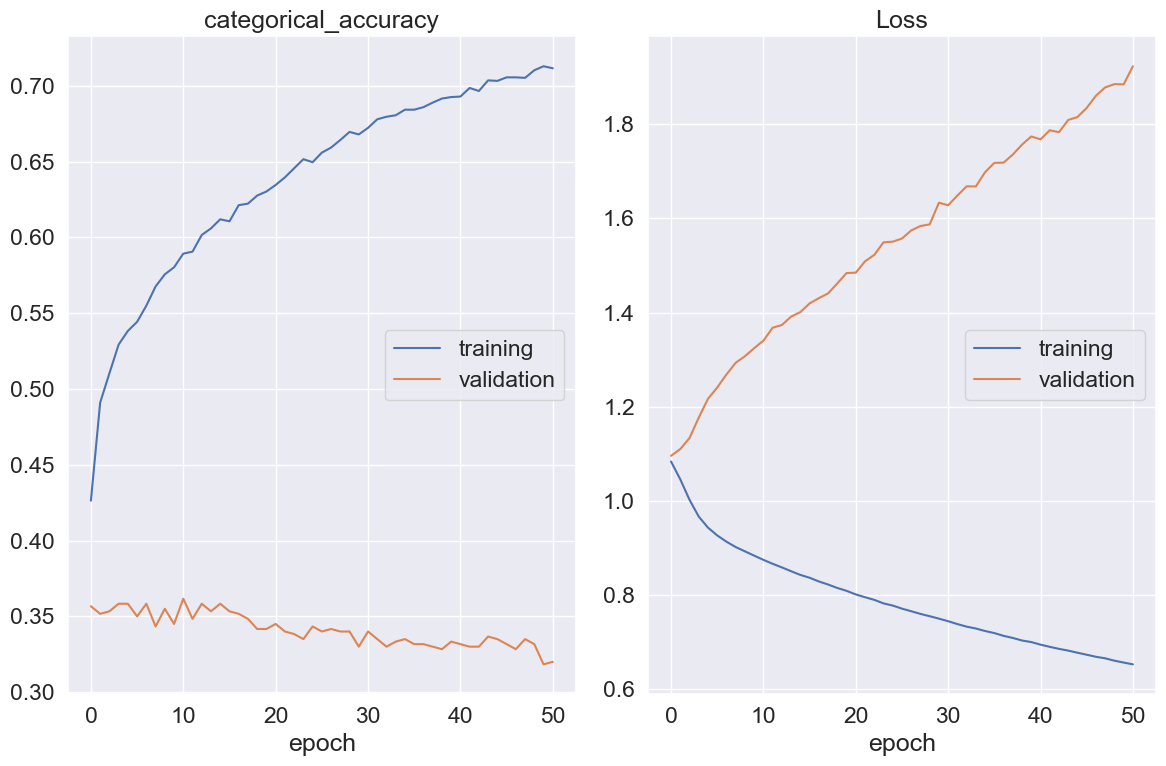

categorical_accuracy
	training         	 (min:    0.426, max:    0.713, cur:    0.712)
	validation       	 (min:    0.318, max:    0.362, cur:    0.320)
Loss
	training         	 (min:    0.653, max:    1.084, cur:    0.653)
	validation       	 (min:    1.096, max:    1.923, cur:    1.923)

Epoch 51: val_loss did not improve from 1.09567
94/94 [==============================] - 1s 6ms/step - loss: 0.6527 - categorical_accuracy: 0.7117 - val_loss: 1.9231 - val_categorical_accuracy: 0.3200
Training time:0:00:28.662386
42/42 [==============================] - 0s 2ms/step - loss: 1.5062 - categorical_accuracy: 0.3749
Accuracy on Test set: 37.49%
42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.6250944822373394 
 MSE =  1.2418745275888132 
 Accuracy =  0.3749055177626606 
 AUC =  0.5361731994385056 
 F1-score =  0.37461517884054807 
 Fbeta =  0.3747743909900152
None


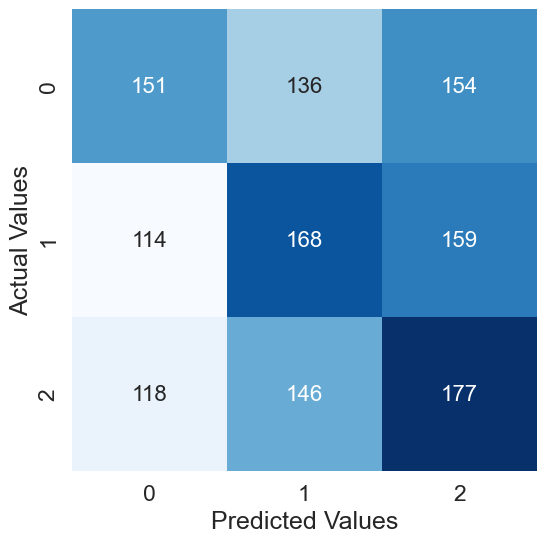

In [18]:
tic = datetime.now()
compile_train(vanilaLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av))

#### StackedLSTM

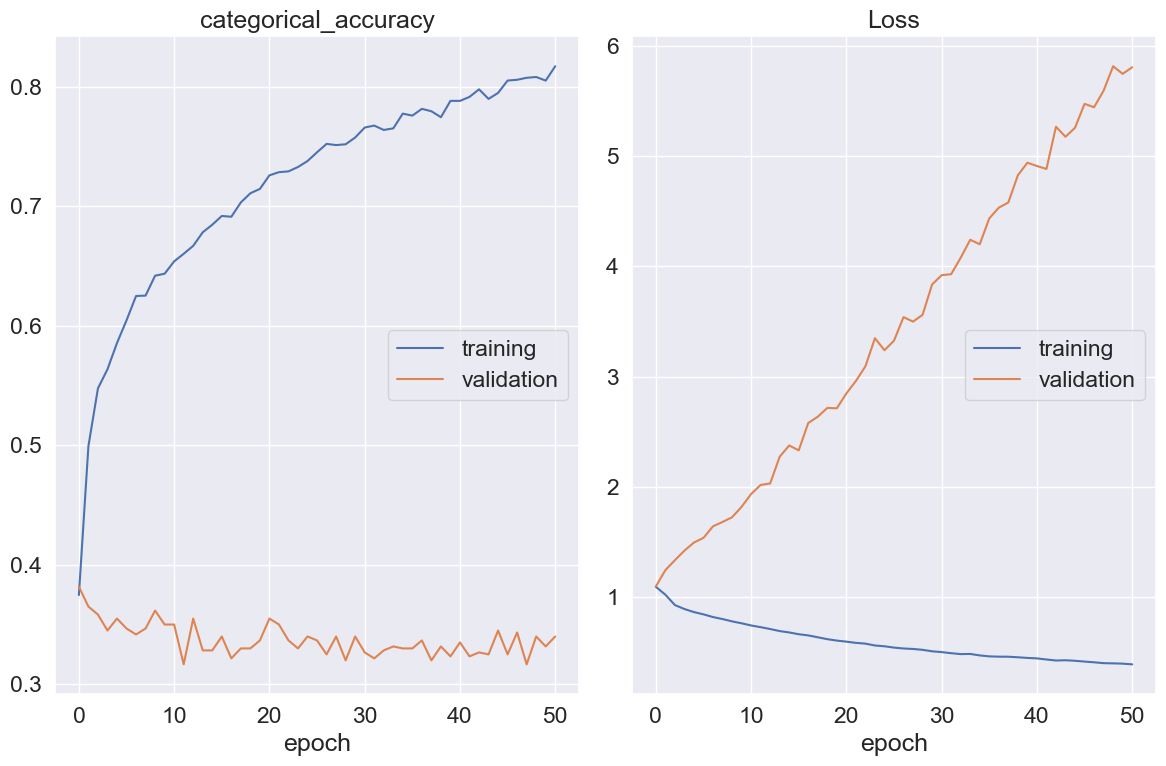

categorical_accuracy
	training         	 (min:    0.375, max:    0.817, cur:    0.817)
	validation       	 (min:    0.317, max:    0.382, cur:    0.340)
Loss
	training         	 (min:    0.390, max:    1.093, cur:    0.390)
	validation       	 (min:    1.095, max:    5.815, cur:    5.806)

Epoch 51: val_loss did not improve from 1.09547
94/94 [==============================] - 1s 9ms/step - loss: 0.3897 - categorical_accuracy: 0.8173 - val_loss: 5.8056 - val_categorical_accuracy: 0.3400
Training time:0:00:43.959196
42/42 [==============================] - 0s 2ms/step - loss: 3.9491 - categorical_accuracy: 0.3628
Accuracy on Test set: 36.28%
42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.63718820861678 
 MSE =  1.2335600907029478 
 Accuracy =  0.36281179138321995 
 AUC =  0.5362786081930883 
 F1-score =  0.36157814587845993 
 Fbeta =  0.3623741745761186
None


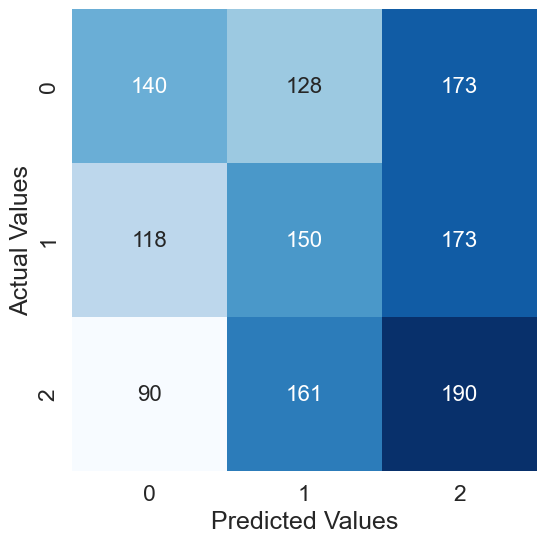

In [19]:
tic = datetime.now()
compile_train(stackedLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(stackedLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(stackedLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test_av, Y_test_av))

#### BiLSTM

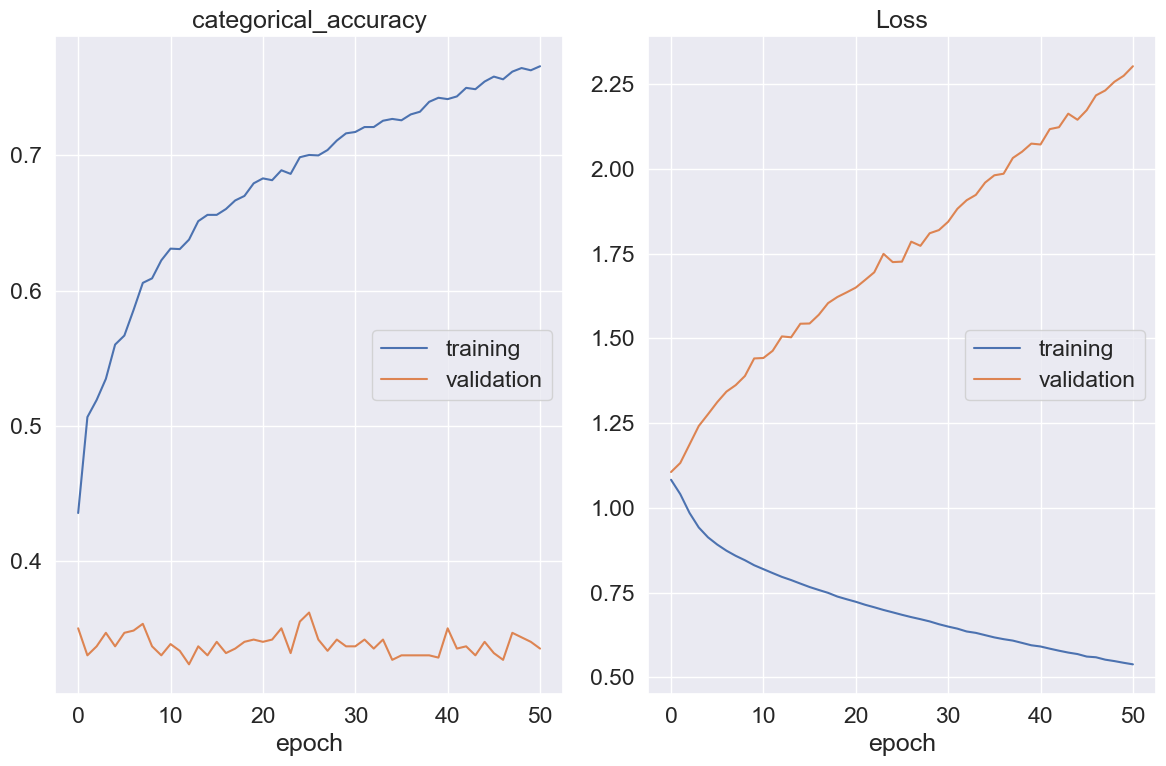

categorical_accuracy
	training         	 (min:    0.435, max:    0.766, cur:    0.766)
	validation       	 (min:    0.323, max:    0.362, cur:    0.335)
Loss
	training         	 (min:    0.539, max:    1.083, cur:    0.539)
	validation       	 (min:    1.106, max:    2.303, cur:    2.303)

Epoch 51: val_loss did not improve from 1.10601
94/94 [==============================] - 1s 9ms/step - loss: 0.5386 - categorical_accuracy: 0.7660 - val_loss: 2.3032 - val_categorical_accuracy: 0.3350
Training time:0:00:42.781136
42/42 [==============================] - 0s 2ms/step - loss: 1.8837 - categorical_accuracy: 0.3447
Accuracy on Test set: 34.47%
42/42 [==============================] - 0s 1ms/step
|biLSTM|
 Error rate = 0.655328798185941 
 MSE =  1.2403628117913832 
 Accuracy =  0.34467120181405897 
 AUC =  0.5130492610246417 
 F1-score =  0.34385385929228596 
 Fbeta =  0.3444458865316511
None


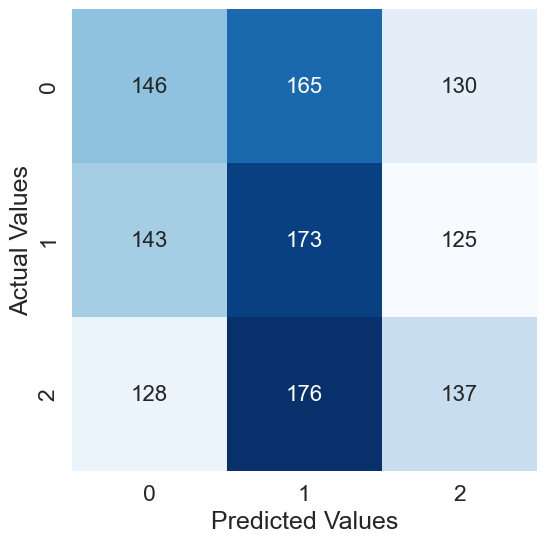

In [20]:
tic = datetime.now()
compile_train(biLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(biLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(biLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test_av, Y_test_av))

#### Multilayer-BiLSTM

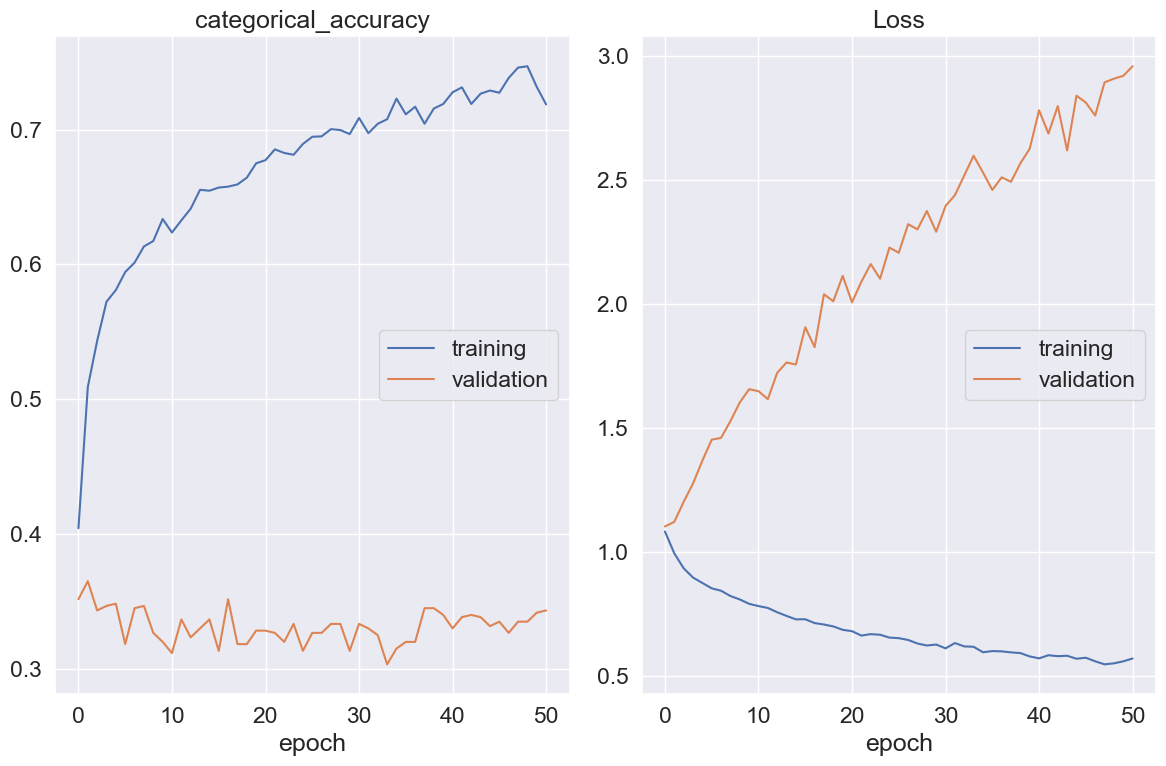

categorical_accuracy
	training         	 (min:    0.404, max:    0.747, cur:    0.719)
	validation       	 (min:    0.303, max:    0.365, cur:    0.343)
Loss
	training         	 (min:    0.548, max:    1.084, cur:    0.572)
	validation       	 (min:    1.104, max:    2.958, cur:    2.958)

Epoch 51: val_loss did not improve from 1.10399
94/94 [==============================] - 1s 8ms/step - loss: 0.5720 - categorical_accuracy: 0.7187 - val_loss: 2.9583 - val_categorical_accuracy: 0.3433
Training time:0:00:43.822436
42/42 [==============================] - 0s 3ms/step - loss: 2.2635 - categorical_accuracy: 0.3689
Accuracy on Test set: 36.89%
42/42 [==============================] - 0s 2ms/step
|bilstm_en|
 Error rate = 0.6311413454270597 
 MSE =  1.1413454270597128 
 Accuracy =  0.3688586545729403 
 AUC =  0.5339750412636709 
 F1-score =  0.3664527563380182 
 Fbeta =  0.3682791069828742
None


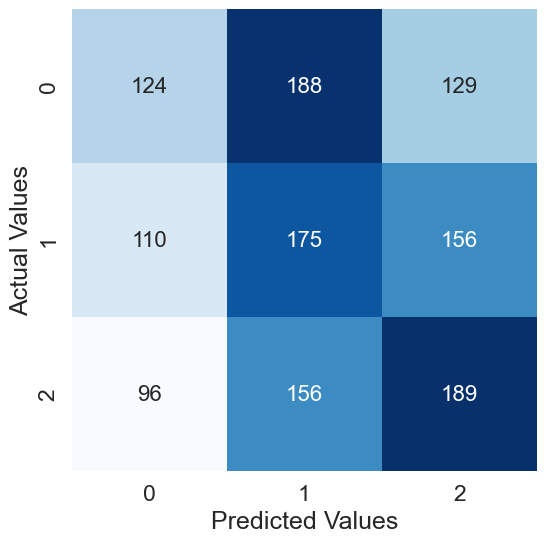

In [21]:
tic = datetime.now()
compile_train(bilstm_en_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(bilstm_en_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(bilstm_en_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = bilstm_en_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(bilstm_en_model,X_test_av, Y_test_av))

## K-Fold Cross Validation

In [22]:
save_dir = '/weights/'
fold_var = 1
#KFold split
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
cvscores_single = []


#### CNN

In [23]:
cvscores = []
tic = datetime.now()
# for train_index, val_index in enumerate(kf.split(X_train_av,Y_train_cat_av)):
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    # print("TRAIN:", train_index, "TEST:", val_index)
    # X_train, X_test = X_train_all[train_index], X_train_all[val_index]
    # Y_train, Y_test = Y_train_all[train_index], Y_train_all[val_index]
     
    CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'

    CNN_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = CNN_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    # print("%s: %f" % (CNN_model.metrics_names[0], scores[0]), "%s: %.2f%%" % (CNN_model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.8302 - categorical_accuracy: 0.6325 - 289ms/epoch - 8ms/step
38/38 - 0s - loss: 0.8313 - categorical_accuracy: 0.7800 - 251ms/epoch - 7ms/step
38/38 - 0s - loss: 0.5006 - categorical_accuracy: 0.8425 - 250ms/epoch - 7ms/step
38/38 - 0s - loss: 0.3352 - categorical_accuracy: 0.8825 - 246ms/epoch - 6ms/step
38/38 - 0s - loss: 0.2181 - categorical_accuracy: 0.9200 - 257ms/epoch - 7ms/step
Training time for 5-fold cv:0:11:06.098676
Mean Accuracy 5-fold cv: 0.811 (0.101)


#### SingleLSTM

In [24]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    vanilaLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    vanilaLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = vanilaLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 0.9799 - categorical_accuracy: 0.6117 - 329ms/epoch - 9ms/step
38/38 - 0s - loss: 0.6360 - categorical_accuracy: 0.7317 - 325ms/epoch - 9ms/step
38/38 - 0s - loss: 0.5395 - categorical_accuracy: 0.7917 - 323ms/epoch - 8ms/step
38/38 - 0s - loss: 0.4520 - categorical_accuracy: 0.8200 - 325ms/epoch - 9ms/step
38/38 - 0s - loss: 0.3410 - categorical_accuracy: 0.8617 - 325ms/epoch - 9ms/step
Training time for 5-fold cv:0:03:47.441843
Mean Accuracy 5-fold cv: 0.763 (0.087)


#### StackedLSTM

In [25]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    stackedLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'
    stackedLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = stackedLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 2.6992 - categorical_accuracy: 0.5792 - 276ms/epoch - 7ms/step
38/38 - 0s - loss: 1.1051 - categorical_accuracy: 0.7708 - 305ms/epoch - 8ms/step
38/38 - 0s - loss: 0.4500 - categorical_accuracy: 0.8717 - 275ms/epoch - 7ms/step
38/38 - 0s - loss: 0.2615 - categorical_accuracy: 0.9233 - 285ms/epoch - 7ms/step
38/38 - 0s - loss: 0.1706 - categorical_accuracy: 0.9417 - 289ms/epoch - 8ms/step
Training time for 5-fold cv:0:06:08.318666
Mean Accuracy 5-fold cv: 0.817 (0.133)


#### Bi-LSTM

In [26]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    biLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    biLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = biLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))


c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 0s - loss: 1.1141 - categorical_accuracy: 0.6092 - 288ms/epoch - 8ms/step
38/38 - 0s - loss: 0.6053 - categorical_accuracy: 0.7475 - 490ms/epoch - 13ms/step
38/38 - 0s - loss: 0.4682 - categorical_accuracy: 0.8150 - 285ms/epoch - 7ms/step
38/38 - 0s - loss: 0.2965 - categorical_accuracy: 0.8758 - 281ms/epoch - 7ms/step
38/38 - 0s - loss: 0.2738 - categorical_accuracy: 0.9000 - 279ms/epoch - 7ms/step
Training time for 5-fold cv:0:05:50.223690
Mean Accuracy 5-fold cv: 0.789 (0.104)


#### Multilayer-BiLSTM

In [27]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    bilstm_en_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])

    bilstm_en_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = bilstm_en_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

c:\Users\hasegawa-lab-pc\miniconda3\envs\cuda112\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/38 - 1s - loss: 0.9653 - categorical_accuracy: 0.6300 - 604ms/epoch - 16ms/step
38/38 - 1s - loss: 0.8731 - categorical_accuracy: 0.6650 - 601ms/epoch - 16ms/step
38/38 - 1s - loss: 0.6165 - categorical_accuracy: 0.7183 - 639ms/epoch - 17ms/step
38/38 - 1s - loss: 0.5280 - categorical_accuracy: 0.7967 - 611ms/epoch - 16ms/step
38/38 - 1s - loss: 0.4446 - categorical_accuracy: 0.8042 - 609ms/epoch - 16ms/step
Training time for 5-fold cv:0:07:48.869522
Mean Accuracy 5-fold cv: 0.723 (0.069)


# Evaluate Model

In [ ]:
# # Compile model to evaluate
# loss = 'categorical_crossentropy' #'mse' #sparse_categorical_crossentropy
# metrics = ['Accuracy','mse'] #['mse'] #
# monitor='val_Accuracy' #loss,Accuracy,mse,val_loss,val_Accuracy,val_mse
# lr=1e-3

# vanilaLSTM_model = vanilaLSTM_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# stackedLSTM_model = bilstm_en_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# biLSTM_model = biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model = bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [ ]:
# vanilaLSTM_model.load_weights('weights/vanilaLSTM.hdf5')
# stackedLSTM_model.load_weights('weights/stackedLSTM.hdf5')
# biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [28]:
#evaluate the model
def evaluate(trainedmodel,Xtest, Ytest_cat):
    mse, acc = trainedmodel.evaluate(Xtest, Ytest_cat,verbose=1)
    print('|'+ trainedmodel.name + '|\n MSE = ', mse, 
      ', Accuracy = ',acc
     )
    return 
print(evaluate(vanilaLSTM_model,X_test_av, Y_test_cat_av)) #X_test, Y_test, 
print(evaluate(stackedLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(biLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(bilstm_en_model,X_test_av, Y_test_cat_av))

42/42 [==============================] - 0s 2ms/step - loss: 8.1594 - categorical_accuracy: 0.3469
|vanilaLSTM|
 MSE =  8.159415245056152 , Accuracy =  0.3469387888908386
None
42/42 [==============================] - 0s 2ms/step - loss: 19.1927 - categorical_accuracy: 0.3961
|stackedLSTM|
 MSE =  19.19269371032715 , Accuracy =  0.3960695266723633
None
42/42 [==============================] - 0s 2ms/step - loss: 11.9367 - categorical_accuracy: 0.3711
|biLSTM|
 MSE =  11.936720848083496 , Accuracy =  0.3711262345314026
None
42/42 [==============================] - 0s 2ms/step - loss: 3.8100 - categorical_accuracy: 0.3787
|bilstm_en|
 MSE =  3.810045003890991 , Accuracy =  0.3786848187446594
None


In [29]:
# evaluate the model by calculating the error rate on the test set

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    acc = accuracy_score(Ytest, pred) #accuracy
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error, 
      '\n MSE = ',mse,
      '\n Accuracy = ',acc
     )
    return cm

print('|confusion matrix|\n', evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av),'\n') #X_train_inv, Y_train, 
print('|confusion matrix|\n', evaluate_error(stackedLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(biLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(bilstm_en_model,X_test_av, Y_test_av),'\n')

42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.6530612244897959 
 MSE =  1.2653061224489797 
 Accuracy =  0.3469387755102041
|confusion matrix|
 [[141 136 164]
 [110 163 168]
 [106 180 155]] 

42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.6039304610733183 
 MSE =  1.1095993953136811 
 Accuracy =  0.3960695389266818
|confusion matrix|
 [[152 145 144]
 [ 86 172 183]
 [ 79 162 200]] 

42/42 [==============================] - 0s 1ms/step
|biLSTM|
 Error rate = 0.6288737717309146 
 MSE =  1.1685563114134543 
 Accuracy =  0.3711262282690854
|confusion matrix|
 [[142 148 151]
 [ 87 159 195]
 [ 87 164 190]] 

42/42 [==============================] - 1s 2ms/step
|bilstm_en|
 Error rate = 0.6213151927437641 
 MSE =  1.124716553287982 
 Accuracy =  0.3786848072562358
|confusion matrix|
 [[109 174 158]
 [ 81 216 144]
 [ 64 201 176]] 



In [30]:
def plot_conf_matrix(model):
    plt.clf()
    ax = plt.subplot()
    cm = evaluate_error(model,X_test_av, Y_test_av)
    # normalize the diagonal entries to know accuracy every class (see the diagonal value) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu") 

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Original')
    ax.set_title('Confusion_matrix')

    classNames = ['not_engaged','normally_engaged','very_engaged']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames, rotation=45)
    plt.show()

    return

42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.6530612244897959 
 MSE =  1.2653061224489797 
 Accuracy =  0.3469387755102041


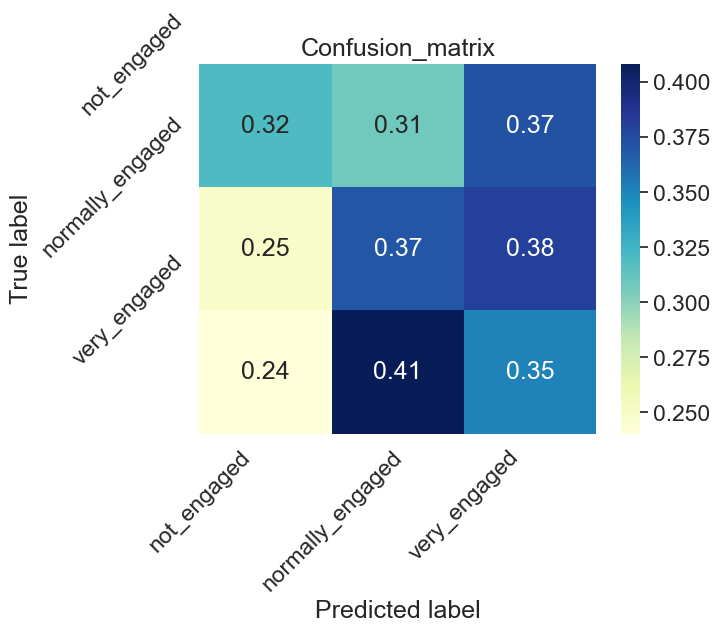

42/42 [==============================] - 0s 1ms/step
|stackedLSTM|
 Error rate = 0.6039304610733183 
 MSE =  1.1095993953136811 
 Accuracy =  0.3960695389266818


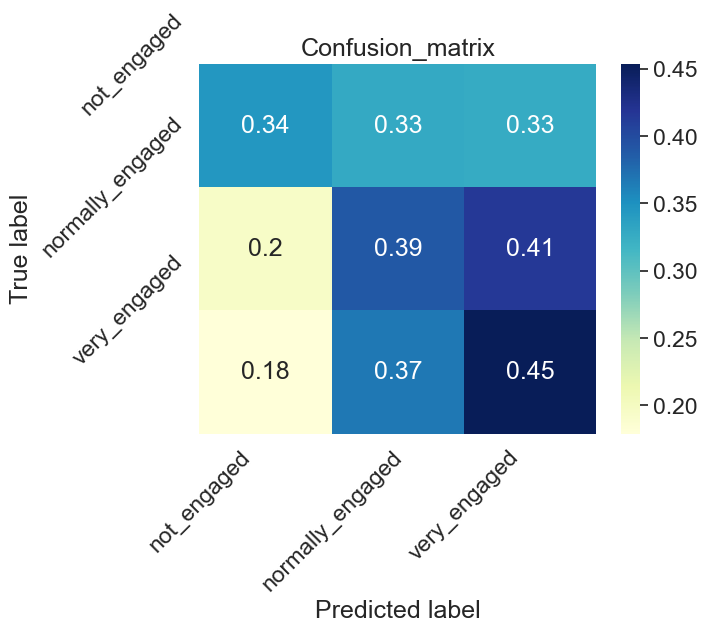

42/42 [==============================] - 0s 2ms/step
|biLSTM|
 Error rate = 0.6288737717309146 
 MSE =  1.1685563114134543 
 Accuracy =  0.3711262282690854


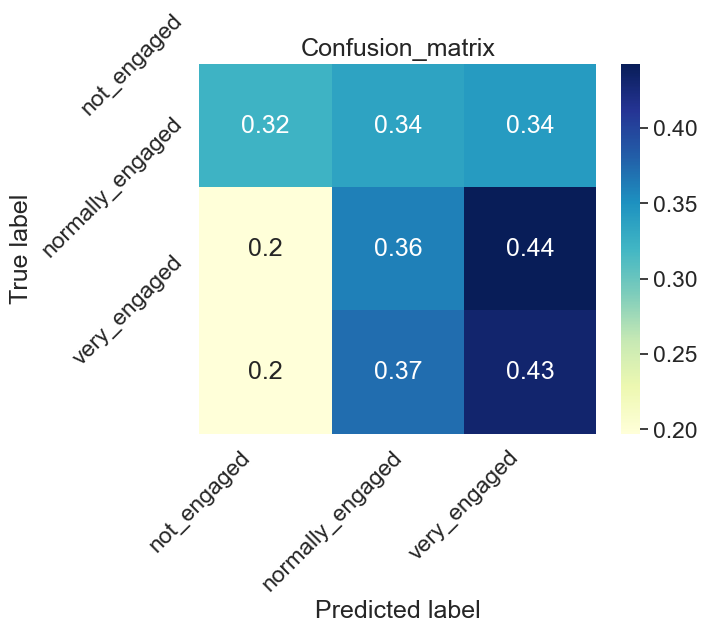

42/42 [==============================] - 0s 2ms/step
|bilstm_en|
 Error rate = 0.6213151927437641 
 MSE =  1.124716553287982 
 Accuracy =  0.3786848072562358


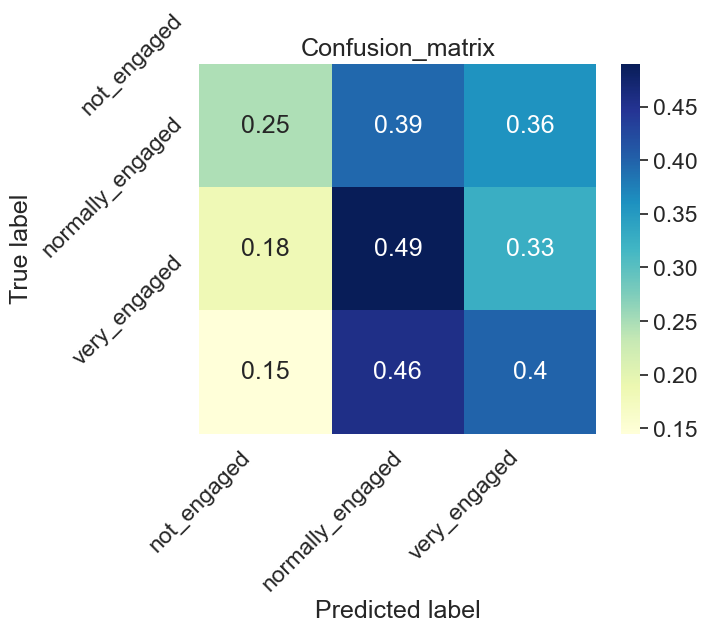

In [31]:
plot_conf_matrix(vanilaLSTM_model)
plot_conf_matrix(stackedLSTM_model)
plot_conf_matrix(biLSTM_model)
plot_conf_matrix(bilstm_en_model)